In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import skimage.io
from scipy.ndimage.filters import convolve

#note: this requires the starter code for the assignments!
from common.plotting import plot_mat

In [4]:
import theano
import theano.tensor.signal.downsample

Using gpu device 0: GeForce GTX 780 (CNMeM is enabled)
/home/i265983/Dokumenty/nn_assignments/libs/Theano/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [5]:
from IPython.display import SVG
def svgdotprint(g):
    return SVG(theano.printing.pydotprint(g, return_image=True, format='svg'))

In [6]:
from fuel.datasets.cifar10 import CIFAR10
from fuel.transformers import ScaleAndShift, Cast, Flatten, Mapping
from fuel.streams import DataStream
from fuel.schemes import SequentialScheme, ShuffledScheme

CIFAR10.default_transformers = (
    (ScaleAndShift, [2.0 / 255.0, -1], {'which_sources': 'features'}),
    (Cast, [np.float32], {'which_sources': 'features'}))

cifar10_train = CIFAR10(("train",), subset=slice(None,40000))
#this stream will shuffle the CIFAR10 set and return us batches of 100 examples
cifar10_train_stream = DataStream.default_stream(
    cifar10_train,
    iteration_scheme=ShuffledScheme(cifar10_train.num_examples, 25))
                                               
cifar10_validation = CIFAR10(("train",), subset=slice(40000, None))

# We will use larger portions for testing and validation
# as these dont do a backward pass and reauire less RAM.
cifar10_validation_stream = DataStream.default_stream(
    cifar10_validation, iteration_scheme=SequentialScheme(cifar10_validation.num_examples, 100))
cifar10_test = CIFAR10(("test",))
cifar10_test_stream = DataStream.default_stream(
    cifar10_test, iteration_scheme=SequentialScheme(cifar10_test.num_examples, 100))

In [7]:
print "The streams return batches containing %s" % (cifar10_train_stream.sources,)

print "Each trainin batch consits of a tuple containing:"
for element in next(cifar10_train_stream.get_epoch_iterator()):
    print " - an array of size %s containing %s" % (element.shape, element.dtype)
    
print "Validation/test batches consits of tuples containing:"
for element in next(cifar10_test_stream.get_epoch_iterator()):
    print " - an array of size %s containing %s" % (element.shape, element.dtype)

The streams return batches containing (u'features', u'targets')
Each trainin batch consits of a tuple containing:
 - an array of size (25, 3, 32, 32) containing float32
 - an array of size (25, 1) containing uint8
Validation/test batches consits of tuples containing:
 - an array of size (100, 3, 32, 32) containing float32
 - an array of size (100, 1) containing uint8


In [8]:
#
# These are taken from https://github.com/mila-udem/blocks
# 

class Constant():
    """Initialize parameters to a constant.
    The constant may be a scalar or a :class:`~numpy.ndarray` of any shape
    that is broadcastable with the requested parameter arrays.
    Parameters
    ----------
    constant : :class:`~numpy.ndarray`
        The initialization value to use. Must be a scalar or an ndarray (or
        compatible object, such as a nested list) that has a shape that is
        broadcastable with any shape requested by `initialize`.
    """
    def __init__(self, constant):
        self._constant = numpy.asarray(constant)

    def generate(self, rng, shape):
        dest = numpy.empty(shape, dtype=np.float32)
        dest[...] = self._constant
        return dest


class IsotropicGaussian():
    """Initialize parameters from an isotropic Gaussian distribution.
    Parameters
    ----------
    std : float, optional
        The standard deviation of the Gaussian distribution. Defaults to 1.
    mean : float, optional
        The mean of the Gaussian distribution. Defaults to 0
    Notes
    -----
    Be careful: the standard deviation goes first and the mean goes
    second!
    """
    def __init__(self, std=1, mean=0):
        self._mean = mean
        self._std = std

    def generate(self, rng, shape):
        m = rng.normal(self._mean, self._std, size=shape)
        return m.astype(np.float32)


class Uniform():
    """Initialize parameters from a uniform distribution.
    Parameters
    ----------
    mean : float, optional
        The mean of the uniform distribution (i.e. the center of mass for
        the density function); Defaults to 0.
    width : float, optional
        One way of specifying the range of the uniform distribution. The
        support will be [mean - width/2, mean + width/2]. **Exactly one**
        of `width` or `std` must be specified.
    std : float, optional
        An alternative method of specifying the range of the uniform
        distribution. Chooses the width of the uniform such that random
        variates will have a desired standard deviation. **Exactly one** of
        `width` or `std` must be specified.
    """
    def __init__(self, mean=0., width=None, std=None):
        if (width is not None) == (std is not None):
            raise ValueError("must specify width or std, "
                             "but not both")
        if std is not None:
            # Variance of a uniform is 1/12 * width^2
            self._width = numpy.sqrt(12) * std
        else:
            self._width = width
        self._mean = mean

    def generate(self, rng, shape):
        w = self._width / 2
        m = rng.uniform(self._mean - w, self._mean + w, size=shape)
        return m.astype(np.float32)

In [31]:
class Layer(object):
    n = 1
    def __init__(self, rng=None):
        if rng == None:
            rng = numpy.random
        self.rng = rng
        self._parameters = []
        self.n = Layer.n
        Layer.n += 1
    
    @property
    def parameters(self):
        return self._parameters
    
    def fprop(self, X):
        return X
    
    def name(self):
        return "Base layer"


class Conv(Layer):
    def __init__(self, num_in, num_out, filter_size=5, weight_init=None, bias_init=None, **kwargs):
        super(Conv, self).__init__(**kwargs)
        if weight_init == None:
            weight_init = IsotropicGaussian(0.05)
        if bias_init == None:
            bias_init = Constant(0.0)
        
        self.weight_init = weight_init
        self.bias_init = bias_init
        self.num_in = num_in
        self.num_out = num_out
        self.filter_size = filter_size
            
        self.W = theano.shared(np.zeros((self.num_out, self.num_in, self.filter_size, self.filter_size), dtype='float32'),
                               name='CW'+str(self.n))
        self.W.tag.initializer = self.weight_init
        self.B = theano.shared(np.zeros((self.num_out,), dtype='float32'),
                               name='CB'+str(self.n))
        self.B.tag.initializer = self.bias_init
        self._parameters = [self.W, self.B]
    
    def fprop(self, X):
        return theano.tensor.nnet.conv2d(X, self.W, border_mode='full') + self.B.dimshuffle('x',0,'x','x')
    
    def name(self):
        return "Convolution layer (%d, %d, %d)" % (self.num_in, self.num_out, self.filter_size)

class ReLU(Layer):
    def __init__(self, **kwargs):
        super(ReLU, self).__init__(**kwargs)
    
    def fprop(self, X):
        return theano.tensor.maximum(0.0, X)
    
    def name(self):
        return "ReLU layer"
    
class MaxPool(Layer):
    def __init__(self, filter_size=2, **kwargs):
        super(MaxPool, self).__init__(**kwargs)
        self.filter_size = filter_size
    
    def fprop(self, X):
        return theano.tensor.signal.downsample.max_pool_2d(X, (self.filter_size,self.filter_size), ignore_border=True)
    
    def name(self):
        return "Max pooling layer (%d x %d)" % (self.filter_size, self.filter_size)
    

class Flatten(Layer):
    def __init__(self, dim, **kwargs):
        super(Flatten, self).__init__(**kwargs)
        self.dim = dim
    
    def fprop(self, X):
        return X.flatten(self.dim)

    def name(self):
        return "Flatten layer (%d)" % (self.dim)
    
class Affine(Layer):
    def __init__(self, num_in, num_out, weight_init=None, bias_init=None, **kwargs):
        super(Affine, self).__init__(**kwargs)
        if weight_init == None:
            weight_init = IsotropicGaussian(std=2./np.sqrt(num_in))
        if bias_init == None:
            bias_init = Constant(0.0)
        
        self.weight_init = weight_init
        self.bias_init = bias_init
        self.num_in = num_in
        self.num_out = num_out
            
        self.W = theano.shared(np.zeros((self.num_in, self.num_out), dtype='float32'),
                               name='AW'+str(self.n))
        self.W.tag.initializer = self.weight_init
        self.B = theano.shared(np.zeros((self.num_out,), dtype='float32'),
                               name='AB'+str(self.n))
        self.B.tag.initializer = self.bias_init
        self._parameters = [self.W, self.B]
    
    def fprop(self, X):
        return theano.tensor.dot(X, self.W) + self.B.dimshuffle('x',0)
    
    def name(self):
        return "Affine layer (%d, %d)" % (self.num_in, self.num_out)

    
class SoftMax(Layer):
    def __init__(self, **kwargs):
        super(SoftMax, self).__init__(**kwargs)
    
    def fprop(self, X):
        return theano.tensor.nnet.softmax(X)
    
    def name(self):
        return "Softmax layer"

    
class Predict(Layer):
    def __init__(self, **kwargs):
        super(Predict, self).__init__(**kwargs)
    
    def fprop(self, X):
        return theano.tensor.argmax(X, axis=1)
    
    def name(self):
        return "Prediction layer"

In [32]:
class FeedForwardNet(object):
    def __init__(self, layers=None):
        if layers == None:
            layers = []
        self.layers = layers
        self.log_probs = None
        self.predictions = None
        self.error_rate = None
        self.nll = None
        self.weight_decay = None
        self.cost = None
    
    @property
    def parameters(self):
        params = []
        for layer in self.layers:
            params += layer.parameters
        return params
    
    def initialize(self, X, wdec_const):
        theano.config.compute_test_value = 'off'
        
        for layer in self.layers:
            X = layer.fprop(X)
        
        self.log_probs = theano.tensor.nnet.softmax(X)
        self.predictions = theano.tensor.argmax(self.log_probs, axis=1)
        self.error_rate = theano.tensor.neq(self.predictions,Y.ravel()).mean()
        self.nll = - theano.tensor.log(self.log_probs[theano.tensor.arange(Y.shape[0]), Y.ravel()]).mean()
        self.weight_decay = 0.0
        for p in self.parameters:
            if p.name[1]=='W':
                self.weight_decay = self.weight_decay + wdec_const * (p**2).sum()
        self.cost = self.nll + self.weight_decay
        
        

In [33]:
X = theano.tensor.tensor4('X')
Y = theano.tensor.matrix('Y', dtype='uint8')
X_test_value, Y_test_value = next(cifar10_train_stream.get_epoch_iterator())
X.tag.test_value = X_test_value[:3]
Y.tag.test_value = Y_test_value[:3]

net = FeedForwardNet(layers=[
        Conv(3, 40, filter_size=5),   ReLU(), MaxPool(2),
        Conv(40, 100, filter_size=5), ReLU(), MaxPool(2),
        Flatten(2),
        Affine(100 * 11 * 11, 800),
        ReLU(),
        Affine(800, 10)
    ])

net.initialize(X, wdec_const=5e-3)

In [35]:
# The updates will update our shared values
updates = []

lrate = theano.tensor.scalar('lrate',dtype='float32')
momentum = theano.tensor.scalar('momentum',dtype='float32')

# Theano will compute the gradients for us
gradients = theano.grad(net.cost, net.parameters)

#initialize storage for momentum
velocities = [theano.shared(np.zeros_like(p.get_value()), name='V_%s' %(p.name, )) for p in net.parameters]

for p,g,v in zip(net.parameters, gradients, velocities):
    v_new = momentum * v - lrate * g
    p_new = p + v_new
    updates += [(v,v_new), (p, p_new)]

updates

[(V_CW1, Elemwise{sub,no_inplace}.0),
 (CW1, Elemwise{add,no_inplace}.0),
 (V_CB1, Elemwise{sub,no_inplace}.0),
 (CB1, Elemwise{add,no_inplace}.0),
 (V_CW4, Elemwise{sub,no_inplace}.0),
 (CW4, Elemwise{add,no_inplace}.0),
 (V_CB4, Elemwise{sub,no_inplace}.0),
 (CB4, Elemwise{add,no_inplace}.0),
 (V_AW8, Elemwise{sub,no_inplace}.0),
 (AW8, Elemwise{add,no_inplace}.0),
 (V_AB8, Elemwise{sub,no_inplace}.0),
 (AB8, Elemwise{add,no_inplace}.0),
 (V_AW10, Elemwise{sub,no_inplace}.0),
 (AW10, Elemwise{add,no_inplace}.0),
 (V_AB10, Elemwise{sub,no_inplace}.0),
 (AB10, Elemwise{add,no_inplace}.0)]

In [36]:
#compile theano functions

#each call to train step will make one SGD step
train_step = theano.function([X,Y,lrate,momentum],[net.cost, net.error_rate, net.nll, net.weight_decay],updates=updates)
#each call to predict will return predictions on a batch of data
predict = theano.function([X], net.predictions)

In [37]:
def compute_error_rate(stream):
    errs = 0.0
    num_samples = 0.0
    for X, Y in stream.get_epoch_iterator():
        errs += (predict(X)!=Y.ravel()).sum()
        num_samples += Y.shape[0]
    return errs/num_samples


#utilities to save values of parameters and to load them

def init_parameters():
    rng = np.random.RandomState(1234)
    for p in net.parameters:
        p.set_value(p.tag.initializer.generate(rng, p.get_value().shape))

def snapshot_parameters():
    return [p.get_value(borrow=False) for p in net.parameters]

def load_parameters(snapshot):
    for p, s in zip(net.parameters, snapshot):
        p.set_value(s, borrow=False)

At minibatch 100, batch loss 16.248087, batch nll 1.604274, batch error rate 56.000000%
At minibatch 200, batch loss 14.200373, batch nll 2.183568, batch error rate 80.000000%
At minibatch 300, batch loss 11.726818, batch nll 1.858489, batch error rate 64.000000%
At minibatch 400, batch loss 9.480042, batch nll 1.370698, batch error rate 40.000000%
At minibatch 500, batch loss 8.211007, batch nll 1.531607, batch error rate 60.000000%
At minibatch 600, batch loss 7.165692, batch nll 1.657004, batch error rate 60.000000%
At minibatch 700, batch loss 5.899021, batch nll 1.343882, batch error rate 48.000000%
At minibatch 800, batch loss 5.757194, batch nll 1.982134, batch error rate 72.000000%
At minibatch 900, batch loss 4.428487, batch nll 1.290509, batch error rate 60.000000%
At minibatch 1000, batch loss 3.984294, batch nll 1.361165, batch error rate 48.000000%
At minibatch 1100, batch loss 3.655833, batch nll 1.457846, batch error rate 48.000000%
At minibatch 1200, batch loss 3.187401

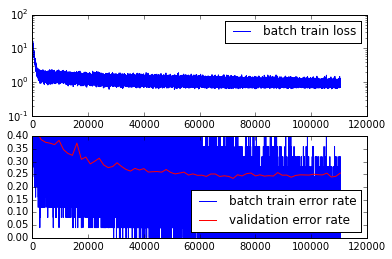

In [38]:
# init training

i=0
e=0

init_parameters()
for v in velocities:
    v.set_value(np.zeros_like(v.get_value()))

best_valid_error_rate = np.inf
best_params = snapshot_parameters()
best_params_epoch = 0

train_erros = []
train_loss = []
train_nll = []
validation_errors = []

number_of_epochs = 3
patience_expansion = 1.5

base_lrate = 1e-2
K = 10000
momentum=0.9

# training loop

try:
    while e<number_of_epochs: #This loop goes over epochs
        e += 1
        #First train on all data from this batch
        epoch_start_i = i
        for X_batch, Y_batch in cifar10_train_stream.get_epoch_iterator(): 
            i += 1
            lrate = base_lrate * K / np.maximum(K, i)

            L, err_rate, nll, wdec = train_step(X_batch, Y_batch, lrate, momentum)

            train_loss.append((i,L))
            train_erros.append((i,err_rate))
            train_nll.append((i,nll))
            if i % 100 == 0:
                print "At minibatch %d, batch loss %f, batch nll %f, batch error rate %f%%" % (i, L, nll, err_rate*100)

        # After an epoch compute validation error
        val_error_rate = compute_error_rate(cifar10_validation_stream)
        if val_error_rate < best_valid_error_rate:
            number_of_epochs = np.maximum(number_of_epochs, e * patience_expansion+1)
            best_valid_error_rate = val_error_rate
            best_params = snapshot_parameters()
            best_params_epoch = e
        validation_errors.append((i,val_error_rate))
        print "After epoch %d: valid_err_rate: %f%% currently going to do %d epochs" %(
            e, val_error_rate*100, number_of_epochs)
        print "After epoch %d: averaged train_err_rate: %f%% averaged train nll: %f averaged train loss: %f" %(
            e, np.mean(np.asarray(train_erros)[epoch_start_i:,1])*100, 
            np.mean(np.asarray(train_nll)[epoch_start_i:,1]),
            np.mean(np.asarray(train_loss)[epoch_start_i:,1]))
except KeyboardInterrupt:
    pass

print "Setting network parameters from after epoch %d" %(best_params_epoch)
load_parameters(best_params)

print "Test error rate: %f" % (compute_error_rate(cifar10_test_stream), )

subplot(2,1,1)
train_loss = np.array(train_loss)
semilogy(train_loss[:,0], train_loss[:,1], label='batch train loss')
legend()

subplot(2,1,2)
train_erros = np.array(train_erros)
plot(train_erros[:,0], train_erros[:,1], label='batch train error rate')
validation_errors = np.array(validation_errors)
plot(validation_errors[:,0], validation_errors[:,1], label='validation error rate', color='r')
ylim(0,0.4)
legend(loc=4)